an ultrastable system incorporates two feedback loops, which can regulate the stable behaviour of the system in response to two corresponding classes of disturbances or perturbations. In addition, an ultrastable system monitors one or more essential variables, and when those variables go outside of the specified viable region, the outer feedback loop adapts the inner one.

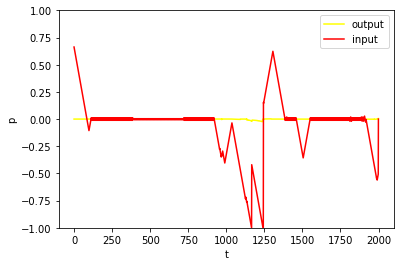

In [1]:
import numpy as np
import matplotlib.pyplot as plt

class Environment:
  def __init__(self, I_n, H_n,O_n, l_rate, weight_formation, edge_formation):
    self.I_n = I_n #input neuron
    self.H_n = H_n #hidden neuron
    self.O_n = O_n #output neuron
    self.l_rate = l_rate
    self.weight_formation = weight_formation
    self.edge_formation = edge_formation
    n_nodes = I_n  + H_n + O_n
    self.n_nodes = n_nodes
    self.weights = [[0 for i in range(n_nodes)]for j in range(n_nodes)] #initialize an empty weight matrix

  def change_weight(self, new_weight, i, j):
    self.weights[i][j] = new_weight

  def formatting(self,i,j):
    if self.weights[j][i] != 0 or i == j: 
      self.change_weight(0, i,j)
    if j < self.I_n: 
      self.change_weight(0, i,j)
    if i >= self.I_n+self.H_n:
      self.change_weight(0, i,j)
    if j >= self.I_n+self.H_n and i < self.I_n:
      self.change_weight(0, i,j)
    if j < self.I_n and i >= self.I_n+self.H_n:
      self.change_weight(0, i,j)



class Regulator:
  def __init__(self,edge_p,weight_w):
    self.edge_p = edge_p
    self.weight_w = weight_w



class Disturber:
  def __init__(self, disturbance_p, edge_p, weight_w):
    self.disturbance_p = disturbance_p
    self.edge_p = edge_p
    self.weight_w = weight_w


T = Environment(1,7,1, 0.05, 0.1, 0.1)
R = Regulator(0.1,0.1)
D = Disturber(0.01, 0.1, 0.01)
E = [] #the system's essential variable 

reg = dis = 0 #flag indicating whether the regulator or the disturber are active
regulatorrecord = [] #record of reg
disturberrecord = [] #record of dis

a = 0 #used by the game
steps = 2000 #number of iterations
dt =1 #iteration timestep
iterations = np.arange(0, steps, dt) #initialize iterations array

y = np.zeros((T.n_nodes, len(iterations))) #initialize y with 0s

E.append(sum([sum(T.weights[i]) for i in range(len(T.weights))])) #first entry of weightrecord.


for t in np.arange(1, len(iterations)): #for each iteration

##### this code was used in Alife project
    inp = y[:, t-1][0] #game's output, network's input 
    if a != 0 and a != 255: #if A is not touching the walls the walls
      if inp <= 0: 
        b = -1
      if inp>0:
        b = 1
      a+=b #move according to A's output
    else:
      a = np.random.randint(0,255) #else teleport A to a random location
      b = np.random.choice((-1,1))
    y[:, t-1][T.n_nodes-1] = (a/255)*2-1 #game's input, network's output 

    # Update network activations
    y[:, t] = np.tanh(T.weights @ y[:, t-1]) #add change in neural activity for each neuron
####################
    absolute_w = [[abs(T.weights[i][j]) for i in range(len(T.weights))] for j in range(len(T.weights[0]))] #abolute value of weights
    E.append(sum([sum(absolute_w[i]) for i in range(len(absolute_w))])) #E is the total sum of weights in the network

    for i in range(len(T.weights[0])): 
      for j in range(len(T.weights)): 

        #generate network edges and weights
        if t>0 and t<=100:
            if T.weights[i][j] == 0 and np.random.rand() < T.edge_formation:#generate edge with probability edge_formation. Edge direction is from most active neuron to least active
              if y[:, t][i] > y[:, t-1][j]:
                T.change_weight(np.random.uniform(-1,1)*T.weight_formation, i,j) 

              if y[:, t][i] < y[:, t-1][j]:
                T.change_weight(np.random.uniform(-1,1)*T.weight_formation, j,i)

            if T.weights[i][j] > -0.1 and T.weights[i][j] < 0.1 and np.random.rand() < T.edge_formation:#delete edge with probability edge_formation
                T.change_weight(0, i, j)



        if t>100: #after network is formed

          #D update
          if np.random.rand() < D.disturbance_p: #on every tick, disturber acts with probability disturbance_p
            dis = 1
            if T.weights[i][j] == 0 and np.random.rand() < D.edge_p:#will generate an edge with probability edge_p
              if y[:, t][i] > y[:, t-1][j]:
                T.change_weight(np.random.uniform(-1,1)*D.weight_w, i,j)

              if y[:, t][i] < y[:, t-1][j]:
                T.change_weight(np.random.uniform(-1,1)*D.weight_w, j,i)

            if T.weights[i][j] > -0.1 and T.weights[i][j] < 0.1 and np.random.rand() < D.edge_p:#will delete an edge with probability edge_p
                T.change_weight(0, i, j)
              
            if T.weights[i][j] != 0  and np.random.rand() < D.edge_p:
                T.change_weight(T.weights[i][j] + np.random.uniform(-1,1)*D.weight_w, i, j)

          
          #T update
          if T.weights[i][j] != 0: #network does hebbian learning on the new set of weights
            T.change_weight(T.weights[i][j] + y[:, t][i]*y[:, t-1][j]*T.l_rate, i, j) 
            T.change_weight(np.tanh(T.weights[i][j]), i, j)#weights are also normalized using  hyperbolic tangent

          #E update
          absolute_w = [[abs(T.weights[i][j]) for i in range(len(T.weights))] for j in range(len(T.weights[0]))] #abolute value of weights
          E[t] = (sum([sum(absolute_w[i]) for i in range(len(absolute_w))])) #E is the total sum of weights in the network
          
          #R update
          if abs(E[t]) > abs(E[t-1]):  #If E increases, regulator kicks in 
            reg = 1
            if T.weights[i][j] == 0 and np.random.rand() < R.edge_p:#will generate an edge with probability edge_p, going from most active neuron to least active neuron 
              if y[:, t][i] > y[:, t-1][j]:
                T.change_weight(np.random.uniform(-1,1)*R.weight_w, i,j)

              if y[:, t][i] < y[:, t-1][j]:
                T.change_weight(np.random.uniform(-1,1)*R.weight_w, j,i)

            if T.weights[i][j] > -0.1 and T.weights[i][j] < 0.1 and np.random.rand() < R.edge_p:#will delete an edge with some probability edge_p 
                  T.change_weight(0, i, j)


        T.formatting(i,j) #formats network as to be directed, and to not contain any self loops

 
    disturberrecord.append(dis) 
    regulatorrecord.append(reg)
    reg = 0
    dis = 0


# plot
_, ax = plt.subplots(1, 1)

plt.ylim([-1,1])
plt.ylabel('p')
plt.xlabel('t')
a, = ax.plot(iterations, y[0, :],'yellow')
b, =ax.plot(iterations, y[T.n_nodes-1, :],'r')
plt.legend([a,b],['output', 'input'])
plt.show()    

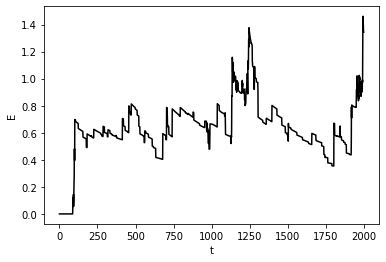

In [2]:
#Record of E over time. The regulator tries to keep E close to 0
plt.ylabel('E')
plt.xlabel('t')
plt.plot(iterations, E, 'k') 

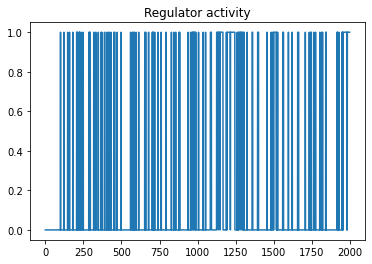

In [3]:
plt.title('Regulator activity')
plt.plot(iterations[:1999], regulatorrecord, )

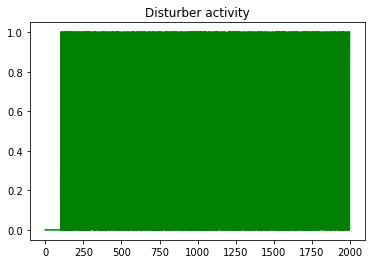

In [4]:
plt.title('Disturber activity')
plt.plot(iterations[:1999], disturberrecord, 'g')
#plt.xlim([1800, 1900])